In [3]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main') 

<IPython.core.display.Javascript object>

In [4]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import warnings
from collections import defaultdict
%matplotlib inline
from matplotlib import rcParams
plt.style.use('seaborn-whitegrid')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

# Import internal classes
from distributions import DistributionShift
from tqdm.notebook import tqdm

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [6]:
from xgboost import XGBRegressor
from tabulate import tabulate

import shap

In [35]:
dataset_classes = [
    Airfoil,
    Concrete,
    FishToxicity,
    #ForestFire,
    #NewTaipeiHousing,
    #PowerPlant,
    #Protein,
    #Servo,
]

In [8]:
for dataset in dataset_classes:
    print(dataset().shape)

(1503, 6)


In [9]:
def initialise_plot(
    num_rows: int, num_cols: int, base_regressor: type, dataset
):
    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(14, 3.5 * num_rows),
    )
    plt.legend()
    fig.suptitle(
        f"Monitoring plot for the {dataset.__name__} dataset under feature drift with {base_regressor.__name__}",
        fontsize=16,
    )
    for j in range(num_cols):
        axs[num_rows - 1, j].set_xlabel("Sorted columnd index")
    for i in range(num_rows):
        axs[i, 0].set_ylabel("Normalised values")
    return fig, axs

In [10]:
def kol_smi(x):
    return ks_2samp(x, BASE_COMP).statistic
def psi_stat(x):
    return psi(x, BASE_COMP)

In [33]:
def monitoring_plot(dataset, base_regressor: type, n_boots: int = 20, **kwargs):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialise the scaler
        standard_scaler = StandardScaler()

        # Load the dataset and split it
        X, _, y, _ = dataset().split(test_size=0.001, random_seed=4242)

        # Scale the dataset
        X = standard_scaler.fit_transform(X)

        # Back to dataframe
        X = pd.DataFrame(X, columns=["Var %d" % (i + 1) for i in range(X.shape[1])])
        data = X.copy()
        data["target"] = y

        # Train test splitting points
        fracc = 0.33
        oneThird = int(data.shape[0] * fracc)
        twoThird = data.shape[0] - int(data.shape[0] * fracc)
        print(
            "Number of rows {}, 1split {}, 2nd split {}".format(
                data.shape[0], oneThird, twoThird
            )
        )

        # Initialize plots
        num_rows = X.shape[1] // 3
        if X.shape[1] % 3 > 0:
            num_rows += 1
        #fig, axs = initialise_plot(num_rows=num_rows,num_cols=3,base_regressor=base_regressor,dataset=dataset)

        shap_res = []

        for idx, col in tqdm(enumerate(X.columns), total=len(X.columns)):
            values = defaultdict(list)

            # Sort data on the column
            data = data.sort_values(col).reset_index(drop=True).copy()

            # Train Test Split
            data_sub = data.iloc[:oneThird]
            data_train = data.iloc[oneThird:twoThird]
            data_up = data.iloc[twoThird:]

            X_tot = data.drop(columns="target")
            X_tr = data_train.drop(columns="target")
            X_sub = data_sub.drop(columns="target")
            X_up = data_up.drop(columns="target")
            X_ood = X_sub.append(X_up)

            y_tot = data[["target"]].target.values
            y_tr = data_train[["target"]].target.values
            y_sub = data_sub[["target"]].target.values
            y_up = data_up[["target"]].target.values

            # Fit the regressor
            regressor = base_regressor()
            regressor.fit(X_tr, y_tr)
            ## Regressor on all data
            regressor_full = base_regressor()
            regressor_full.fit(X_tot, y_tot)

            # Predictions
            preds = regressor.predict(X_tot)

            # explain the model's predictions using SHAP
            explainer = shap.Explainer(regressor)
            shap_values = explainer(X_ood)
            #shap_values = pd.DataFrame(data=shap_values.values, columns=X_tot.columns)
            #return shap_values
            plt.figure()
            tit = str(idx)+str(col)
            plt.title(tit)
            shap.plots.bar(shap_values)
            plt.show()
            shap.plots.beeswarm(shap_values)
            shap.plots.waterfall(shap_values[0])

            
            


Number of rows 1501, 1split 495, 2nd split 1006


  0%|          | 0/5 [00:00<?, ?it/s]

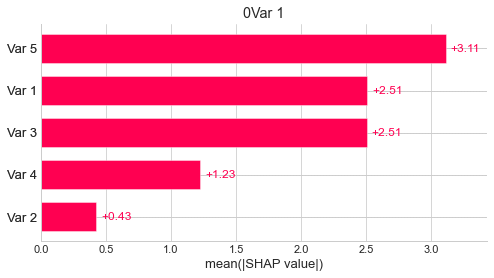

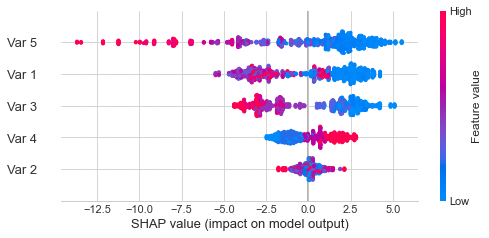

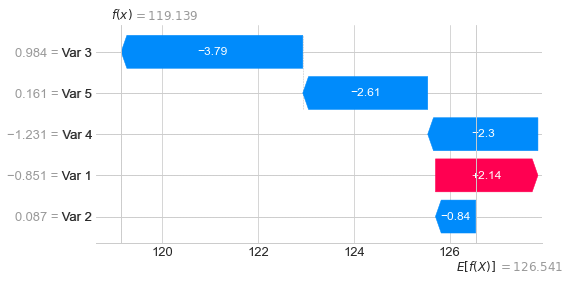

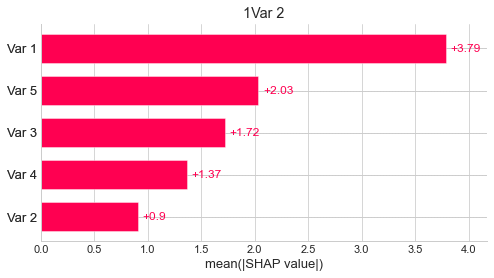

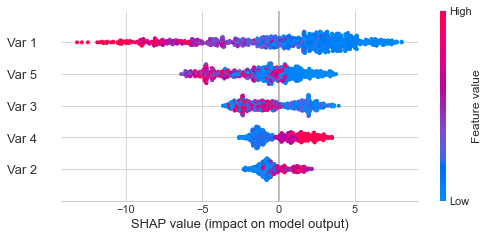

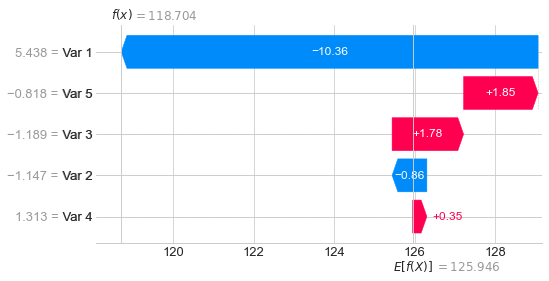

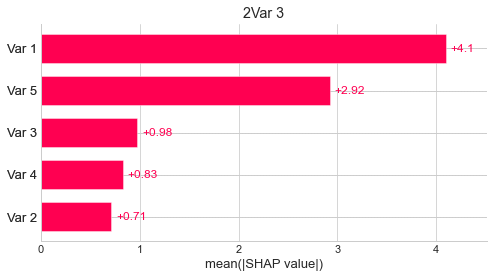

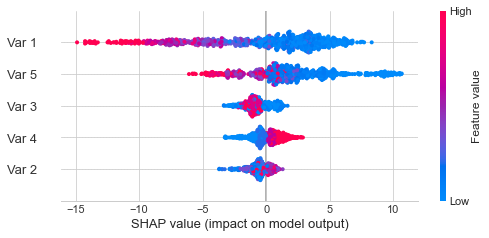

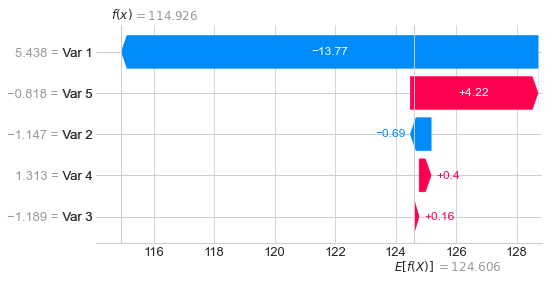

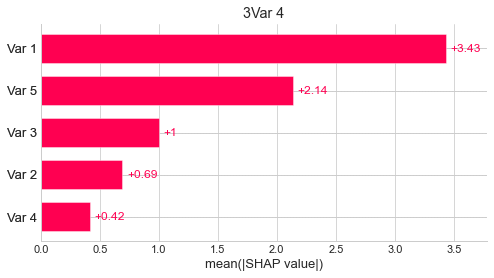

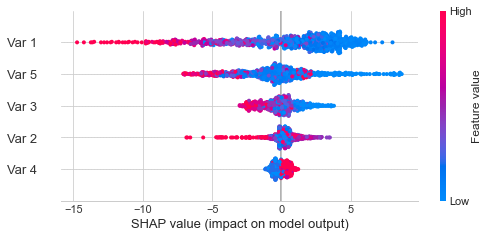

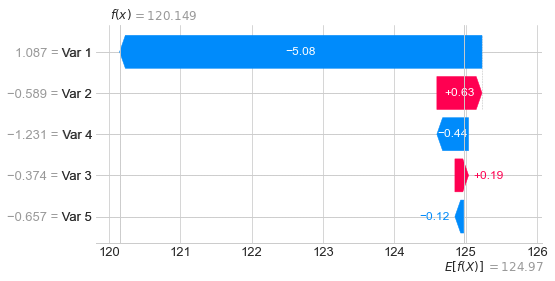

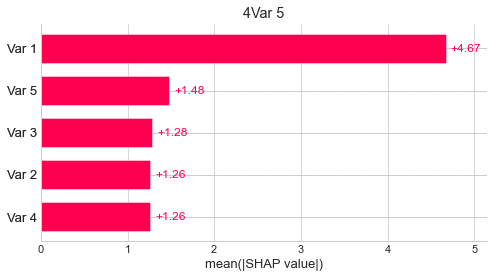

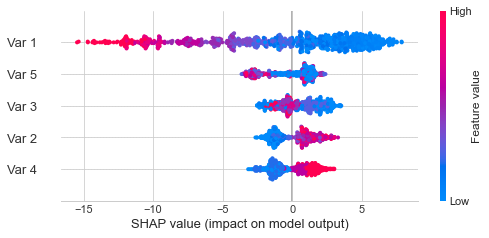

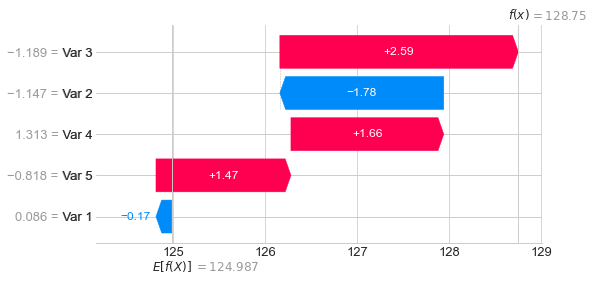

Number of rows 1028, 1split 339, 2nd split 689


  0%|          | 0/8 [00:00<?, ?it/s]

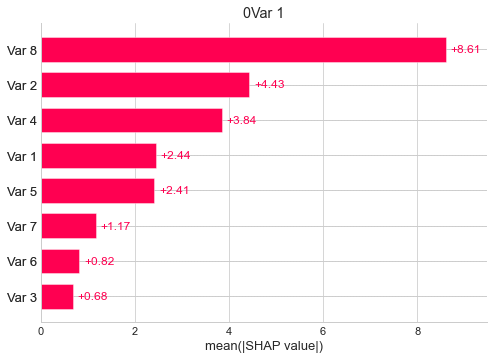

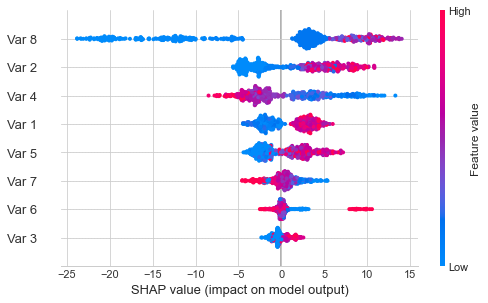

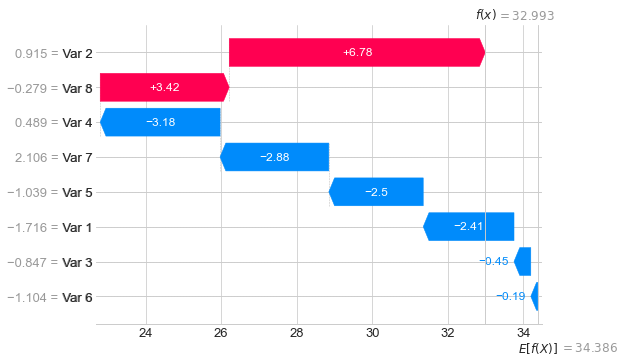

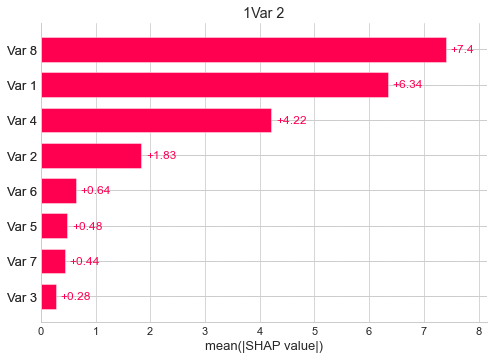

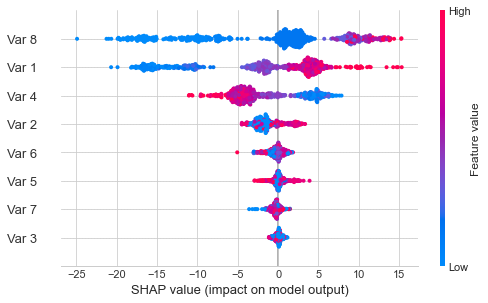

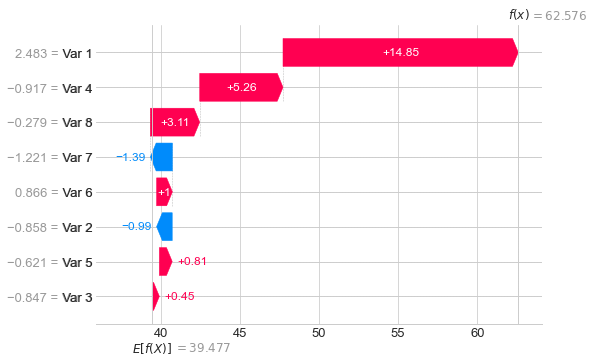

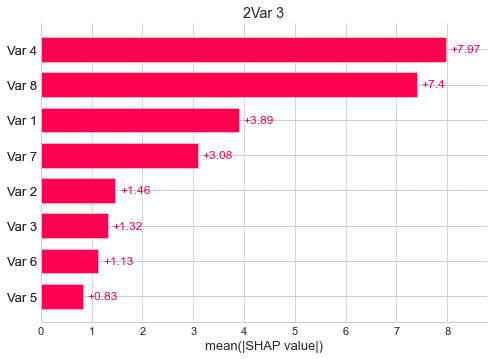

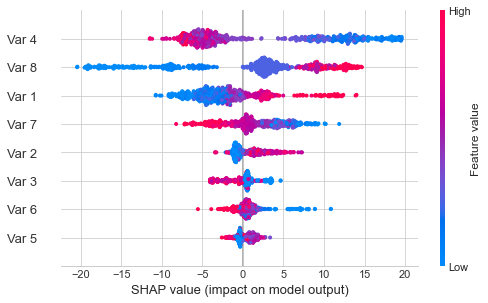

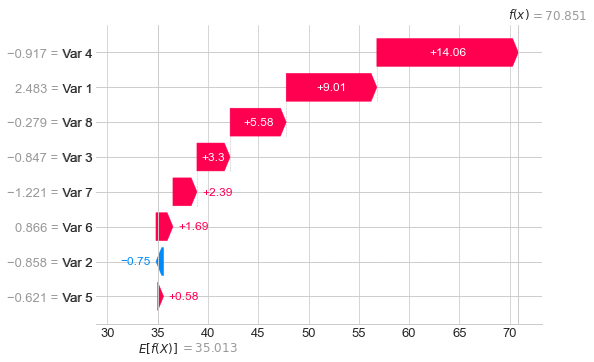

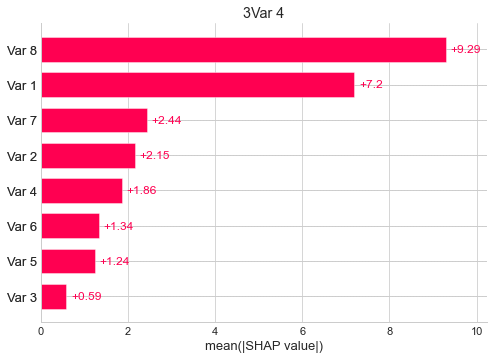

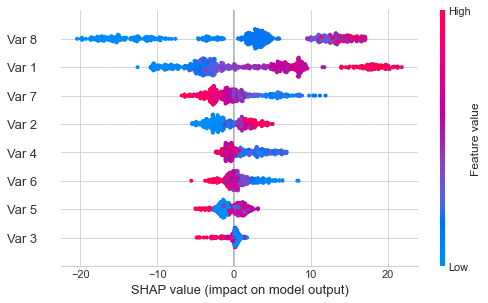

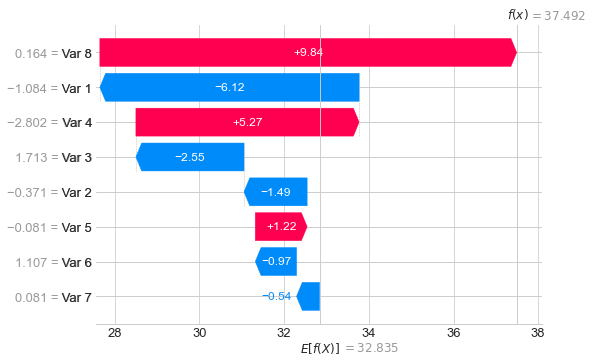

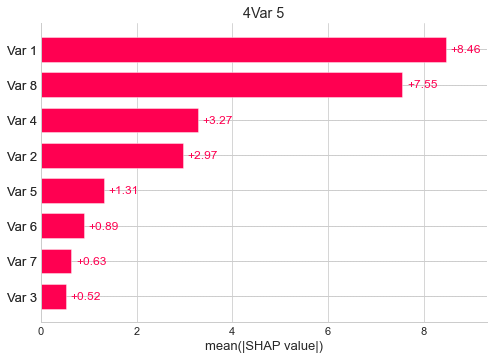

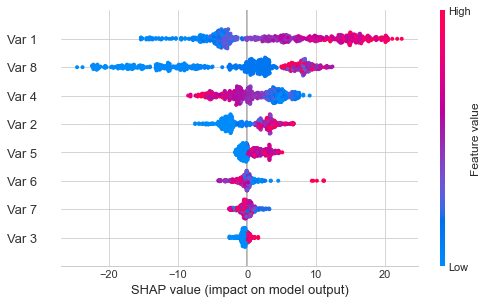

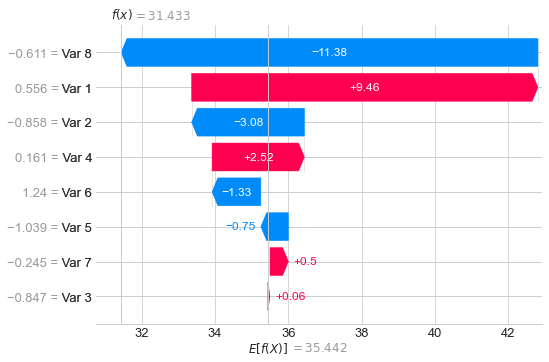

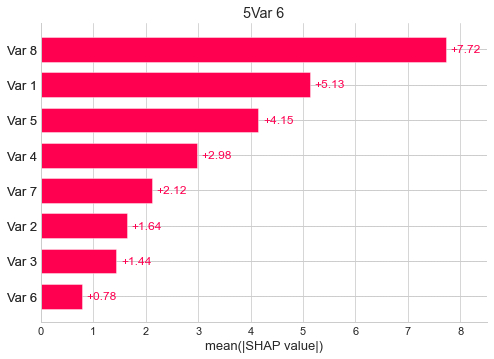

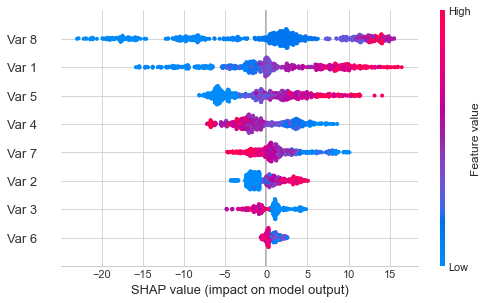

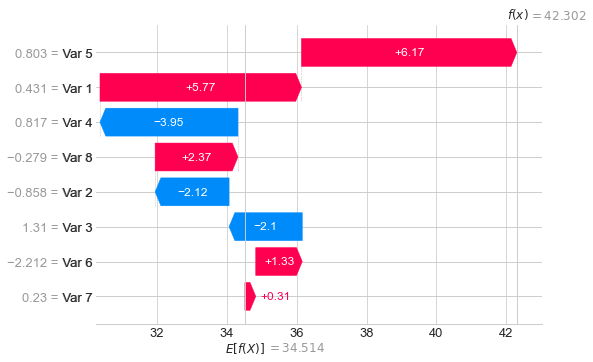

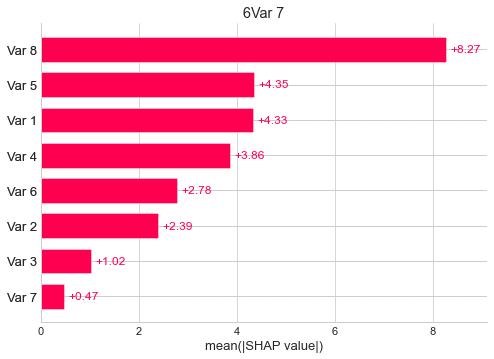

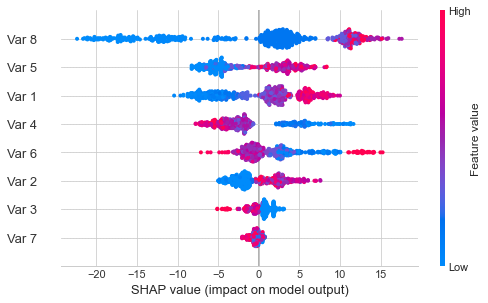

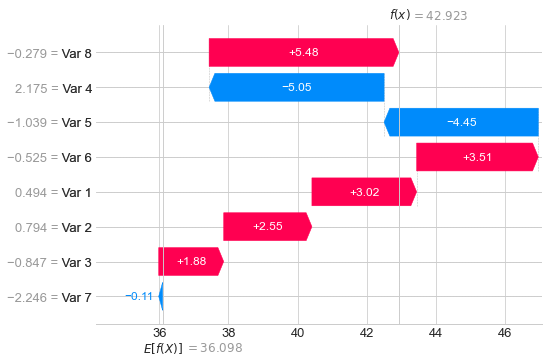

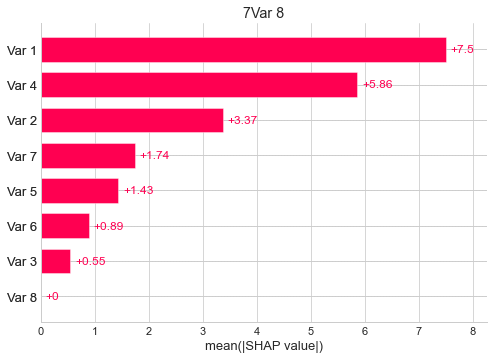

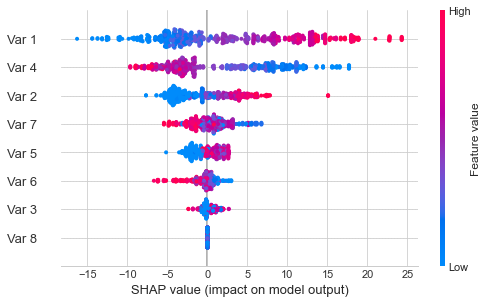

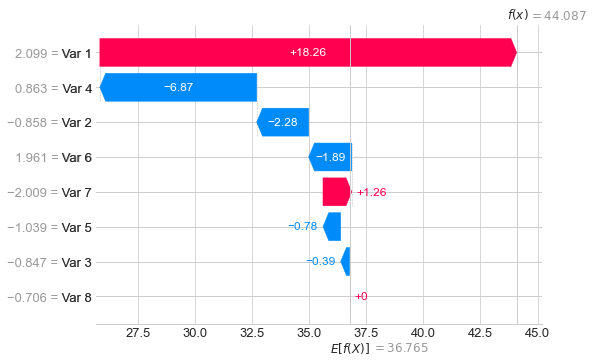

Number of rows 906, 1split 298, 2nd split 608


  0%|          | 0/6 [00:00<?, ?it/s]

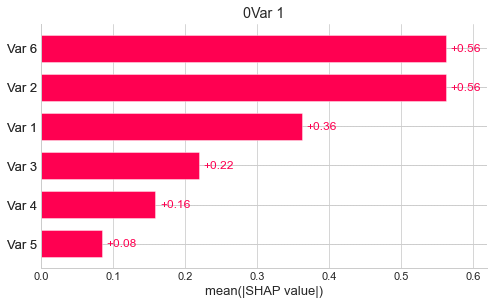

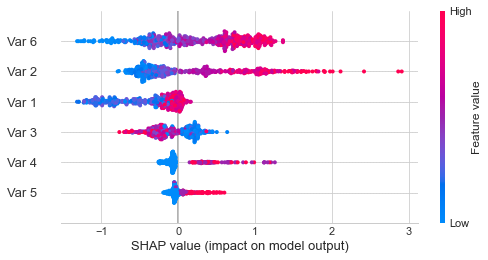

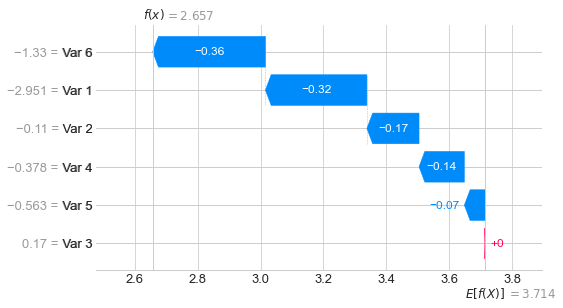

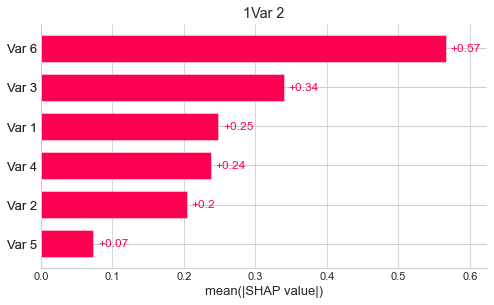

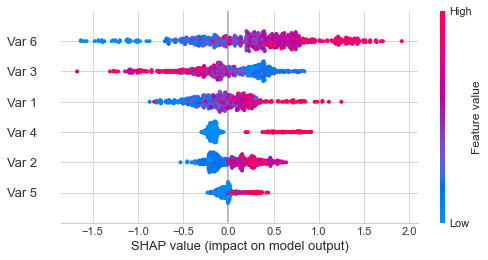

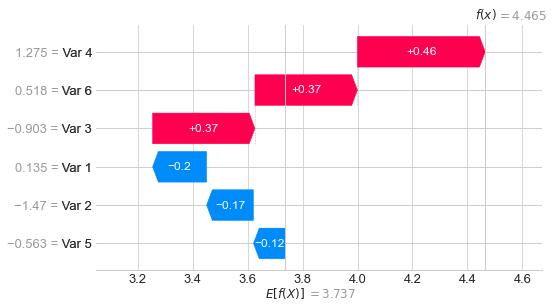

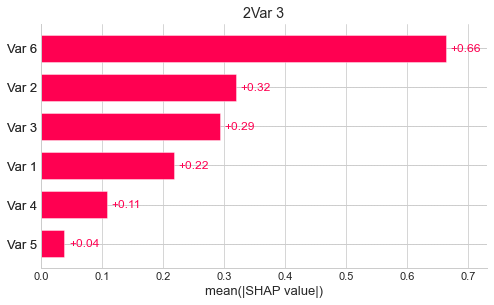

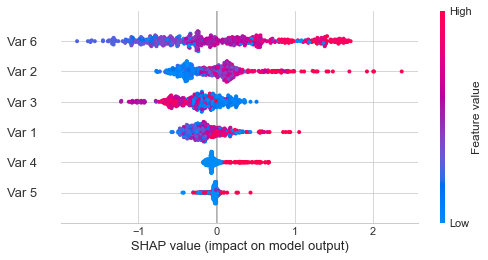

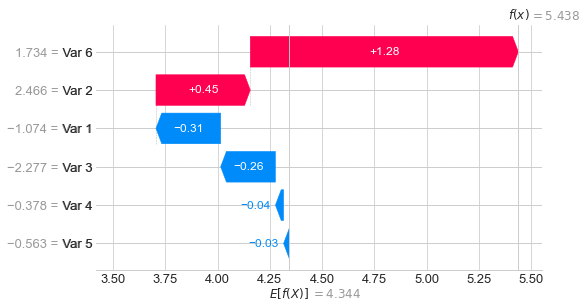

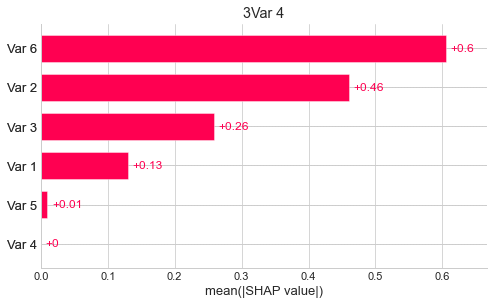

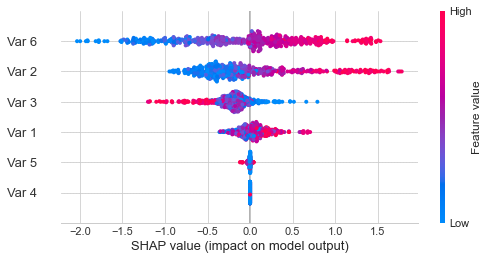

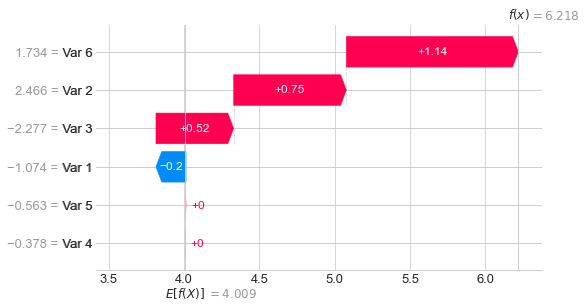

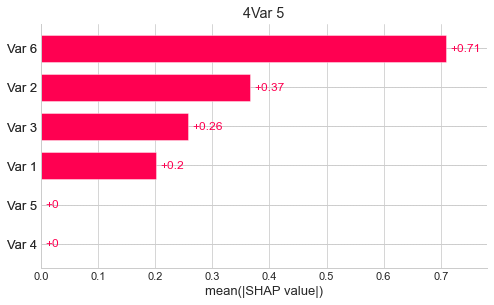

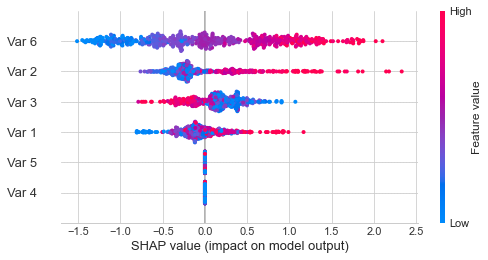

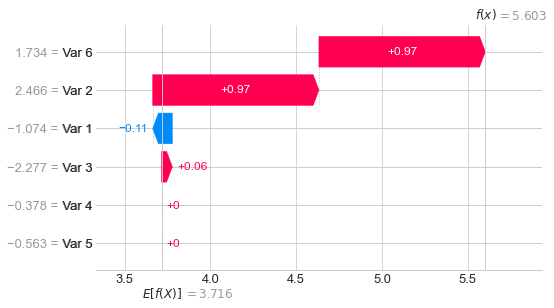

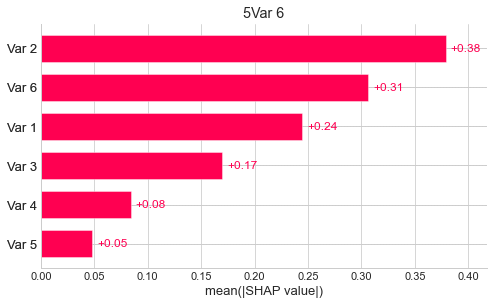

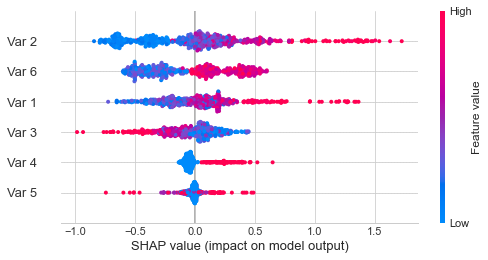

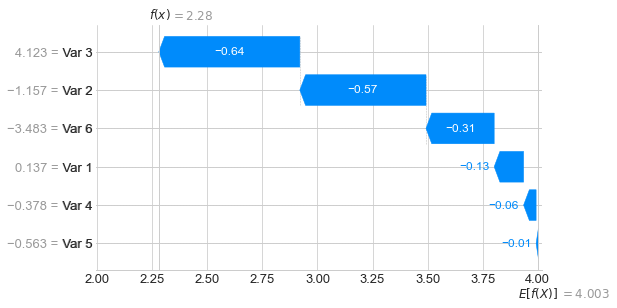

In [36]:
for dataset in dataset_classes:
     a = monitoring_plot(dataset, XGBRegressor)

In [22]:
a

In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset, DecisionTreeRegressor,max_depth=20)
    #monitoring_plot(dataset,RandomForestRegressor)



In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,RandomForestRegressor,n_estimators = 20)



In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,XGBRegressor)



In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,MLPRegressor)



Q:

More explanation types?
    Can we compare with this method to argumentation methods?
More data types?
    Saliency maps on images

